In [88]:
import matplotlib
import numpy as np
import pandas as pd

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# https://zhuanlan.zhihu.com/p/56507515
# https://zhuanlan.zhihu.com/p/410655154
# https://zhuanlan.zhihu.com/p/21275919

In [89]:
src_path = 'indexProcessed.csv'
test_size = 0.1               # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                        # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [90]:
df = pd.read_csv(src_path, sep = ",")
# df = df.drop(df.columns[[0]], axis = 1)
del df['Index']
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...
104219,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


In [91]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

/tmp/ipykernel_71751/2103356123.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,closeusd,month
40920,1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0.0,12.577200,1
40921,1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0.0,12.639900,1
40922,1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0.0,12.742700,1
40923,1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0,12.864301,1
40924,1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0.0,12.885400,1
40925,1965-01-13,1281.670044,1281.670044,1281.670044,1281.670044,1281.670044,0.0,12.816700,1
40926,1965-01-14,1289.500000,1289.500000,1289.500000,1289.500000,1289.500000,0.0,12.895000,1
40927,1965-01-18,1271.680054,1271.680054,1271.680054,1271.680054,1271.680054,0.0,12.716801,1
40928,1965-01-19,1270.339966,1270.339966,1270.339966,1270.339966,1270.339966,0.0,12.703400,1
40929,1965-01-20,1268.880005,1268.880005,1268.880005,1268.880005,1268.880005,0.0,12.688800,1


Text(0.5, 0, 'date')

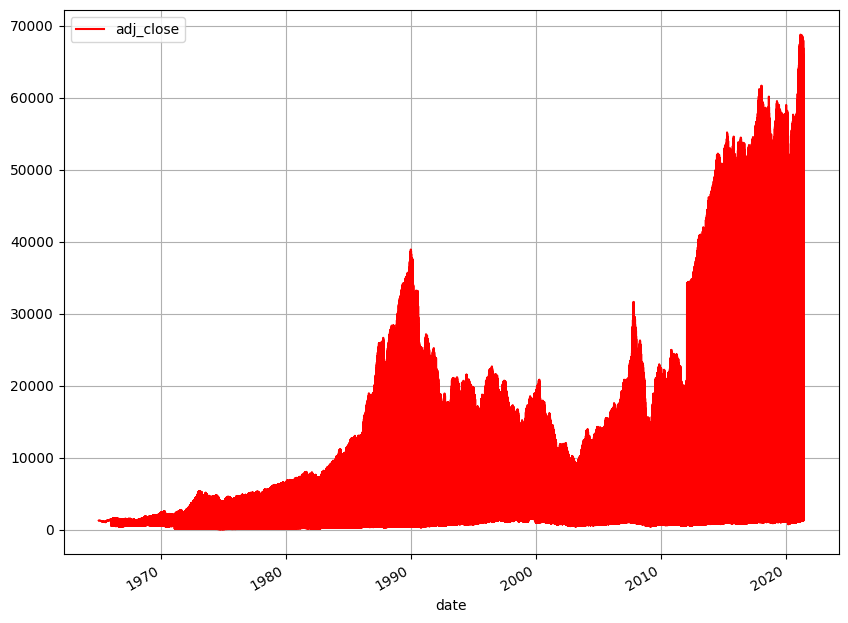

In [92]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x = 'date', y = 'adj_close', style = 'r-', grid = True)
ax.set_xlabel("date")
# df.plot(x = 'date', y = 'adj_close', marker = ',', markevery = 10, color = 'r', ls = '-', lw = 2)

In [93]:
# Get sizes of each of the datasets
num_cv, num_test = int(cv_size*len(df)), int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("total_num = " + str(len(df)) )
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train: num_train + num_cv]
train_cv = df[:num_train + num_cv]
test = df[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

total_num = 104224
num_train = 72958
num_cv = 20844
num_test = 10422
train.shape = (72958, 9)
cv.shape = (20844, 9)
train_cv.shape = (93802, 9)
test.shape = (10422, 9)


Text(0, 0.5, 'USD')

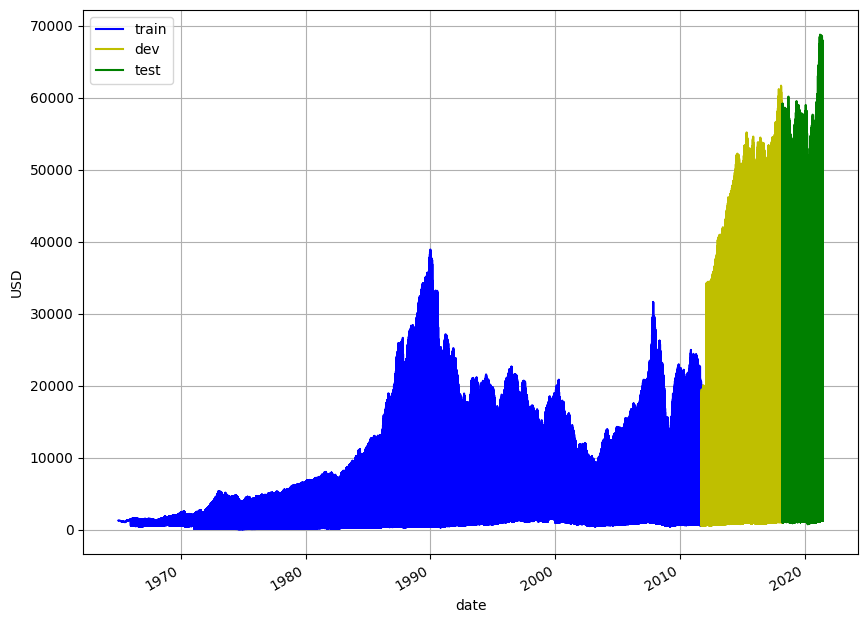

In [94]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x = 'date', y = 'adj_close', style = 'b-', grid = True)
ax = cv.plot(x = 'date', y = 'adj_close', style = 'y-', grid = True, ax = ax)
ax = test.plot(x = 'date', y = 'adj_close', style = 'g-', grid = True, ax = ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [95]:
# X_train,Y_train = df['date'][:num_train], df['adj_close'][:num_train]
# X_test,Y_test = df['date'][num_train:], df['adj_close'][num_train:]
X_train, Y_train = df[:num_train], df[:num_train].adj_close
X_test, Y_test = df[num_train:], df[num_train:].adj_close
# Y_train = df.pop('adj_close')
# X_train = df.pop('date')

date_val = X_test['date']
del X_train['adj_close']
del X_train['date']
del X_train['closeusd']
del X_test['adj_close']
del X_test['date']
del X_test['closeusd']

# X_train = X_train['open'].values.reshape(-1, 1)
# X_test = X_test['open'].values.reshape(-1, 1)

mean = Y_train.mean()
print(mean)
Y_train = Y_train.fillna(mean, inplace=False) 

mean = X_train.mean()
X_train = X_train.fillna(mean, inplace=False) 

# mean = X_test.mean()
# X_test = X_test.fillna(mean, inplace=False) 

# mean = Y_test.mean()
# Y_test = Y_test.fillna(mean, inplace=False) 
# # X_train = X_train.values.reshape(-1, 1)

print(X_train, Y_train)
# print(X_test, Y_test)

5656.598557168878
               open          high           low         close        volume  \
40920   1257.719971   1257.719971   1257.719971   1257.719971  0.000000e+00   
40921   1263.989990   1263.989990   1263.989990   1263.989990  0.000000e+00   
40922   1274.270020   1274.270020   1274.270020   1274.270020  0.000000e+00   
40923   1286.430054   1286.430054   1286.430054   1286.430054  0.000000e+00   
40924   1288.540039   1288.540039   1288.540039   1288.540039  0.000000e+00   
...             ...           ...           ...           ...           ...   
19993   7355.169922   7355.169922   7012.589844   7045.009766  4.586370e+09   
99507   7568.220215   7651.270020   7547.000000   7610.569824  2.094200e+06   
93582   5520.109863   5536.609863   5430.770020   5430.770020  5.801000e+07   
63670  10990.509770  11101.709960  10850.500000  10892.389650  3.310000e+04   
85883   5383.629883   5400.790039   5174.240234   5189.930176  2.293139e+08   

       month  
40920      1  
409

In [96]:
# from sklearn import linear_model
# reg = linear_model.Ridge(alpha=.5)
# # score = get_score(X_train, y_train)
# reg.fit(X_train, Y_train)
# reg.coef_
# reg.intercept_

from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)
regr.coef_
regr.intercept_

-0.43823743712619034

In [97]:
# from sklearn.metrics import median_absolute_error

# y_pred = reg.predict(X_train)

# mae = median_absolute_error(Y_train, y_pred)
# string_score = f"MAE on training set: {mae:.2f} $/hour"
# y_pred = reg.predict(X_test)
# mae = median_absolute_error(Y_test, y_pred)
# string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

Y_pred = regr.predict(X_test)
print(Y_pred, len(Y_pred))

from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

[ 8737.4099945  12387.73978583  5059.16722338 ... 28946.35233649
  1263.21720357 29058.24075684] 31266
Coefficients: 
 [-1.05835254e-04  7.08857768e-04 -5.22412691e-04  9.99932283e-01
  1.49716409e-11  2.25234929e-03]
Mean squared error: 0.09
Coefficient of determination: 1.00


31266 31266


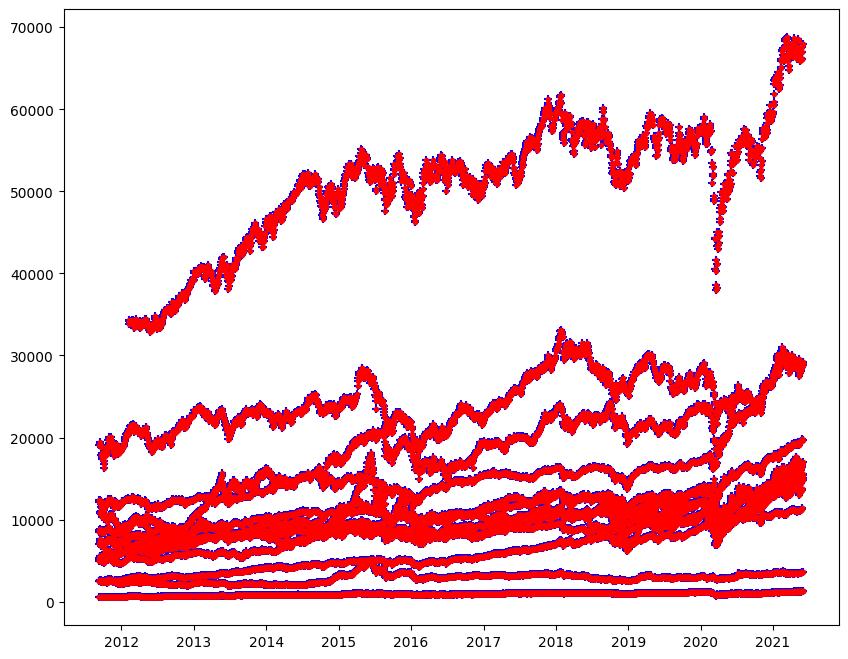

In [98]:
print(len(Y_pred), len(Y_test))
ax = plt.scatter(date_val, Y_test, color="blue", marker = '+')
bx = plt.scatter(date_val, Y_pred, color="red", marker = '.')
plt.show()

In [101]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(Y_test, Y_pred))

times = 0
diff = 0
for i in Y_test:
    if int(i) != int(Y_pred[times]):
        # print("different", i, Y_pred[times])
        diff += 1
        if (int(i) - int(Y_pred[times]) >= 1):
            print("different", i, Y_pred[times])
    times += 1
print(diff, "%.2f%%" % (diff / len(Y_pred)))

0.9999999994877085
different 5303.140137 5302.850330138311
different 2495.090088 2494.7692748476843
different 5359.140137 5358.853618351623
different 2471.304932 2470.9324501257897
different 2532.149902 2531.8202421596584
different 554.109985 553.7157478067354
different 5340.189941 5339.996705692669
different 2479.054932 2478.681677031968
different 7329.100098 7328.981389383537
different 2607.070068 2606.7372179899994
different 2622.310059 2621.9826656249375
different 8864.160156 8863.91398619095
different 5084.25 5083.943954474288
different 2482.343018 2481.9718165950217
different 8721.240234 8720.976450872447
different 7217.109863 7216.934019612876
different 5140.200195 5139.920539197611
different 2590.23999 2589.918566696752
different 564.090027 563.6932443077582
different 8741.160156 8740.898397782701
different 5133.25 5132.933187772575
different 2538.189941 2537.8841812110177
different 5164.209961 5163.955467455359
different 2443.055908 2442.7050036663513
different 7046.194336 704

In [100]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X_test, Y_test, cv=5)
print(scores)

[1. 1. 1. 1. 1.]
